In [20]:
import torch

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob

from model import ADModel
from dataset import MVTecAD

### CAM on trained model for bottle

#### Load dataset

In [21]:

def load_dataset(category:str, mode = "test"):
    size = 256
    test_transform = transforms.Compose([])
    test_transform.transforms.append(transforms.Resize((size,size)))
    test_transform.transforms.append(transforms.ToTensor())
    test_transform.transforms.append(transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                        std=[0.229, 0.224, 0.225]))
    test_data_eval = MVTecAD("Data", category, size, transform = test_transform, mode=mode)
    dataloader_test = DataLoader(test_data_eval, batch_size=64,
                                        shuffle=False, num_workers=0)


    vis_transform = transforms.Compose([])
    vis_transform.transforms.append(transforms.Resize((size,size)))
    vis_transform.transforms.append(transforms.ToTensor())

    vis_data_eval = MVTecAD("Data", category, size, transform = vis_transform, mode=mode)
    dataloader_vis = DataLoader(vis_data_eval, batch_size=64,
                                        shuffle=False, num_workers=0)

    return dataloader_test, test_data_eval, dataloader_vis, vis_data_eval

    

#### load models

In [22]:
def load_model(category:str):
    models_path = glob.glob("./models/*.tch")
    model_path = [path for path in models_path if category in path][0]
    
    device="cuda"
    weights = torch.load(model_path)
    head_layer = 2
    head_layers = [512]*head_layer+[128]
    classes = weights["out.weight"].shape[0]
    print(f"classes: {classes}")
    model = ADModel(pretrained=True, head_layers=head_layers, num_classes=classes)
    model.load_state_dict(weights)
    model.to(device)
    model.eval()
    return model

#### get firts batch for visualization

In [23]:
dataloader_test, test_data_eval, dataloader_vis, vis_data_eval = load_dataset("bottle")

input_tensor, it_labels = next(iter(dataloader_test))
vis_input_tensor, vit_labels = next(iter(dataloader_vis))

#### grayscale CAM for the first batch

In [24]:
# %reload_ext autoreload
model = load_model("bottle") 
target_layers = [model.resnet18.layer4[-1]]
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)


# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cams = cam(input_tensor=input_tensor, targets=None)

classes: 3


/home/eam/Projects/shikun/3-anomaly-detection/self-supervised/ADSelfSupervised/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/eam/Projects/shikun/3-anomaly-detection/self-supervised/ADSelfSupervised/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [40]:
def create_visualization(grayscale_cams, labels, vis_data_eval, vis_input_tensor):

    defets_idx = np.where(labels.cpu().detach().numpy() ==True)[0]
    defect_idx = defets_idx[0]
    grayscale_cam = grayscale_cams[defect_idx, :]

    actual_img_norm = vis_input_tensor[defect_idx].cpu().detach().numpy()
    actual_img_norm = np.moveaxis(actual_img_norm, 0, 2)


    defect_cam_heatmap = show_cam_on_image(actual_img_norm.copy(), grayscale_cam, use_rgb=True)


    normalizedImg = np.zeros((256, 256))
    normalizedImg = cv2.normalize(grayscale_cam,  normalizedImg, 0, 255, cv2.NORM_MINMAX)
    _, binary_cam = cv2.threshold(normalizedImg, 180, 255,cv2.THRESH_BINARY)
    binary_cam = binary_cam.astype(np.uint8)

    defect_img_path = str(vis_data_eval.image_names[defect_idx])
    print(f"defect_img_path: {defect_img_path}")
    actual_img = cv2.cvtColor(cv2.resize(cv2.imread(defect_img_path), (256,256)), cv2.COLOR_RGB2BGR)
    # # binary_cam.astype(np.uint8)
    contours, hierarchy = cv2.findContours(binary_cam, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    segmented_defect = cv2.drawContours(actual_img, contours, -1, (0,255,0), 3)


    ground_truth_mask_path = defect_img_path.replace("test", "ground_truth").replace(".png", "_mask.png")
    ground_truth_mask = cv2.cvtColor(cv2.resize(cv2.imread(ground_truth_mask_path), (256,256)), cv2.COLOR_RGB2BGR)
    return actual_img_norm, defect_cam_heatmap, binary_cam, segmented_defect,ground_truth_mask

defect_img_path: Data/zipper/test/squeezed_teeth/004.png
ground_truth_mask_path:  Data/zipper/ground_truth/squeezed_teeth/004_mask.png


Text(0.5, 1.0, 'ground truth mask')

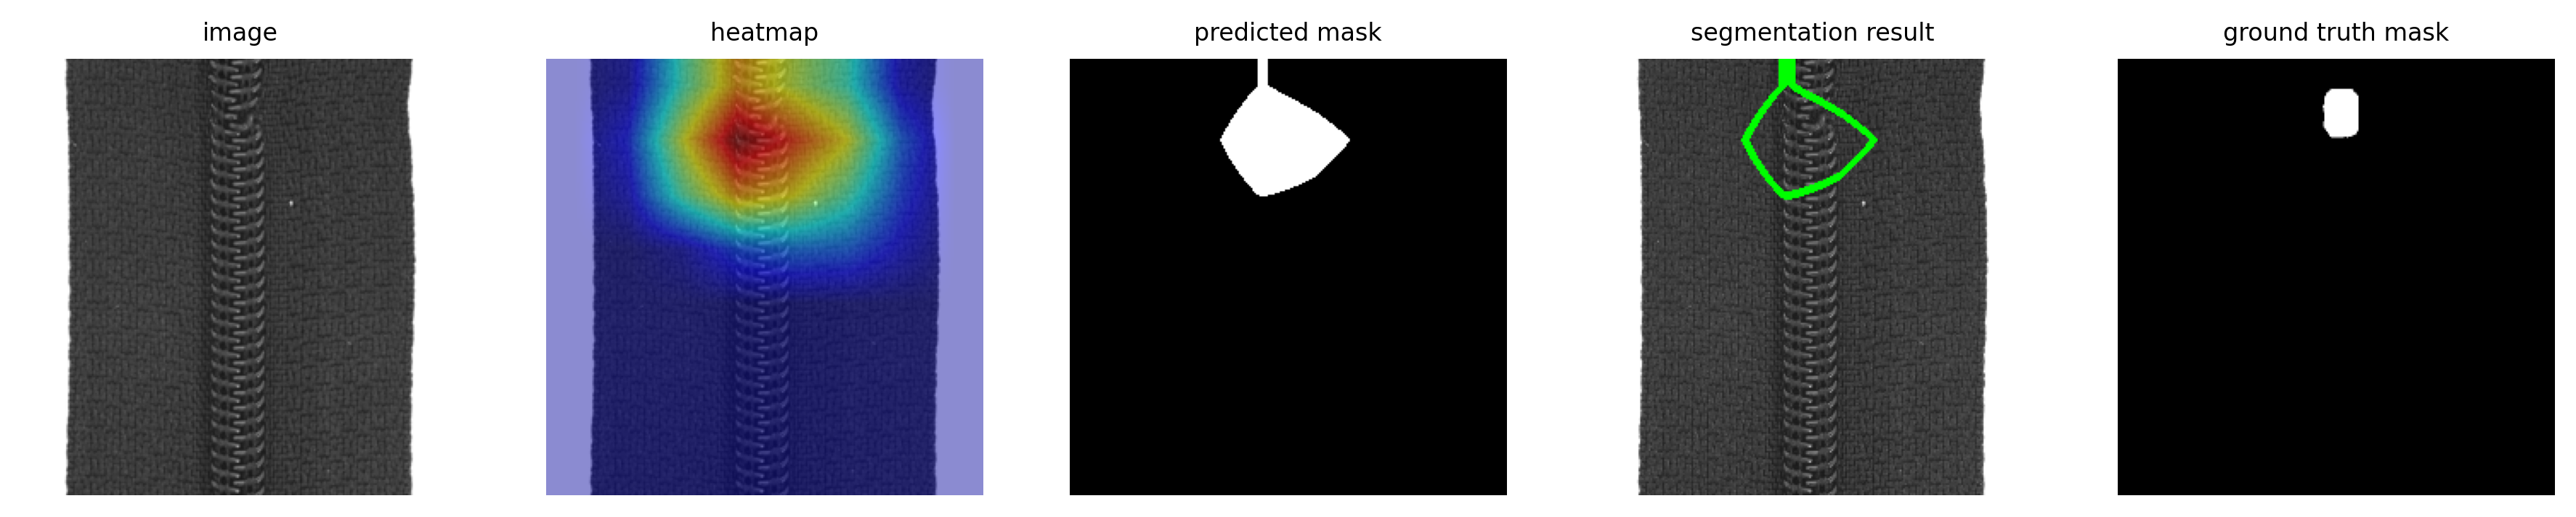

In [48]:
plt.rcParams["figure.figsize"] = (15,10)
plt.rcParams['figure.dpi'] = 300

actual_img_norm, defect_cam_heatmap, binary_cam, segmented_defect,ground_truth_mask = create_visualization(grayscale_cams, it_labels, vis_data_eval, vis_input_tensor)
fontdict={'fontsize':8}
fig, axes = plt.subplots(1,5)
fig.set_dpi(300)
axes[0].imshow(actual_img_norm)
axes[0].axis("off")
axes[0].set_title("image", fontdict=fontdict)
axes[1].imshow(defect_cam_heatmap)
axes[1].axis("off")
axes[1].set_title("heatmap", fontdict=fontdict)
axes[2].imshow(binary_cam, cmap='gray')
axes[2].axis("off")
axes[2].set_title("predicted mask", fontdict=fontdict)
axes[3].imshow(segmented_defect)
axes[3].axis("off")
axes[3].set_title("segmentation result", fontdict=fontdict)

axes[4].imshow(ground_truth_mask)
axes[4].axis("off")
axes[4].set_title("ground truth mask", fontdict=fontdict)

#### generate HeatMap using GradCam

In [44]:
categories = ["bottle", "cable", "capsule", "carpet", "grid", "hazelnut", "leather", "metal_nut", "pill", "screw", "tile", "toothbrush", "transistor", "wood", "zipper"]
visualizations = []
for category in  categories:
    dataloader_test, test_data_eval, dataloader_vis, vis_data_eval = load_dataset(category)
    input_tensor, it_labels = next(iter(dataloader_test))
    vis_input_tensor, vit_labels = next(iter(dataloader_vis))

    model = load_model(category)

    target_layers = [model.resnet18.layer4[-1]]
    cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
    grayscale_cams = cam(input_tensor=input_tensor, targets=None)

    actual_img_norm, defect_cam_heatmap, binary_cam, segmented_defect,ground_truth_mask = create_visualization(grayscale_cams, it_labels, vis_data_eval, vis_input_tensor)
    visualizations.append([actual_img_norm, defect_cam_heatmap, binary_cam, segmented_defect,ground_truth_mask])
    
    del model
    del cam
    torch.cuda.empty_cache()
    
    

classes: 3


/home/eam/Projects/shikun/3-anomaly-detection/self-supervised/ADSelfSupervised/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/eam/Projects/shikun/3-anomaly-detection/self-supervised/ADSelfSupervised/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


defect_img_path: Data/bottle/test/broken_large/019.png
ground_truth_mask_path:  Data/bottle/ground_truth/broken_large/019_mask.png
classes: 3
defect_img_path: Data/cable/test/cable_swap/004.png
ground_truth_mask_path:  Data/cable/ground_truth/cable_swap/004_mask.png
classes: 3
defect_img_path: Data/capsule/test/faulty_imprint/020.png
ground_truth_mask_path:  Data/capsule/ground_truth/faulty_imprint/020_mask.png
classes: 3
defect_img_path: Data/carpet/test/hole/004.png
ground_truth_mask_path:  Data/carpet/ground_truth/hole/004_mask.png
classes: 3
defect_img_path: Data/grid/test/bent/004.png
ground_truth_mask_path:  Data/grid/ground_truth/bent/004_mask.png
classes: 3
defect_img_path: Data/hazelnut/test/print/004.png
ground_truth_mask_path:  Data/hazelnut/ground_truth/print/004_mask.png
classes: 3
defect_img_path: Data/leather/test/glue/018.png
ground_truth_mask_path:  Data/leather/ground_truth/glue/018_mask.png
classes: 3
defect_img_path: Data/metal_nut/test/scratch/020.png
ground_truth_

IndexError: index 4 is out of bounds for axis 0 with size 4

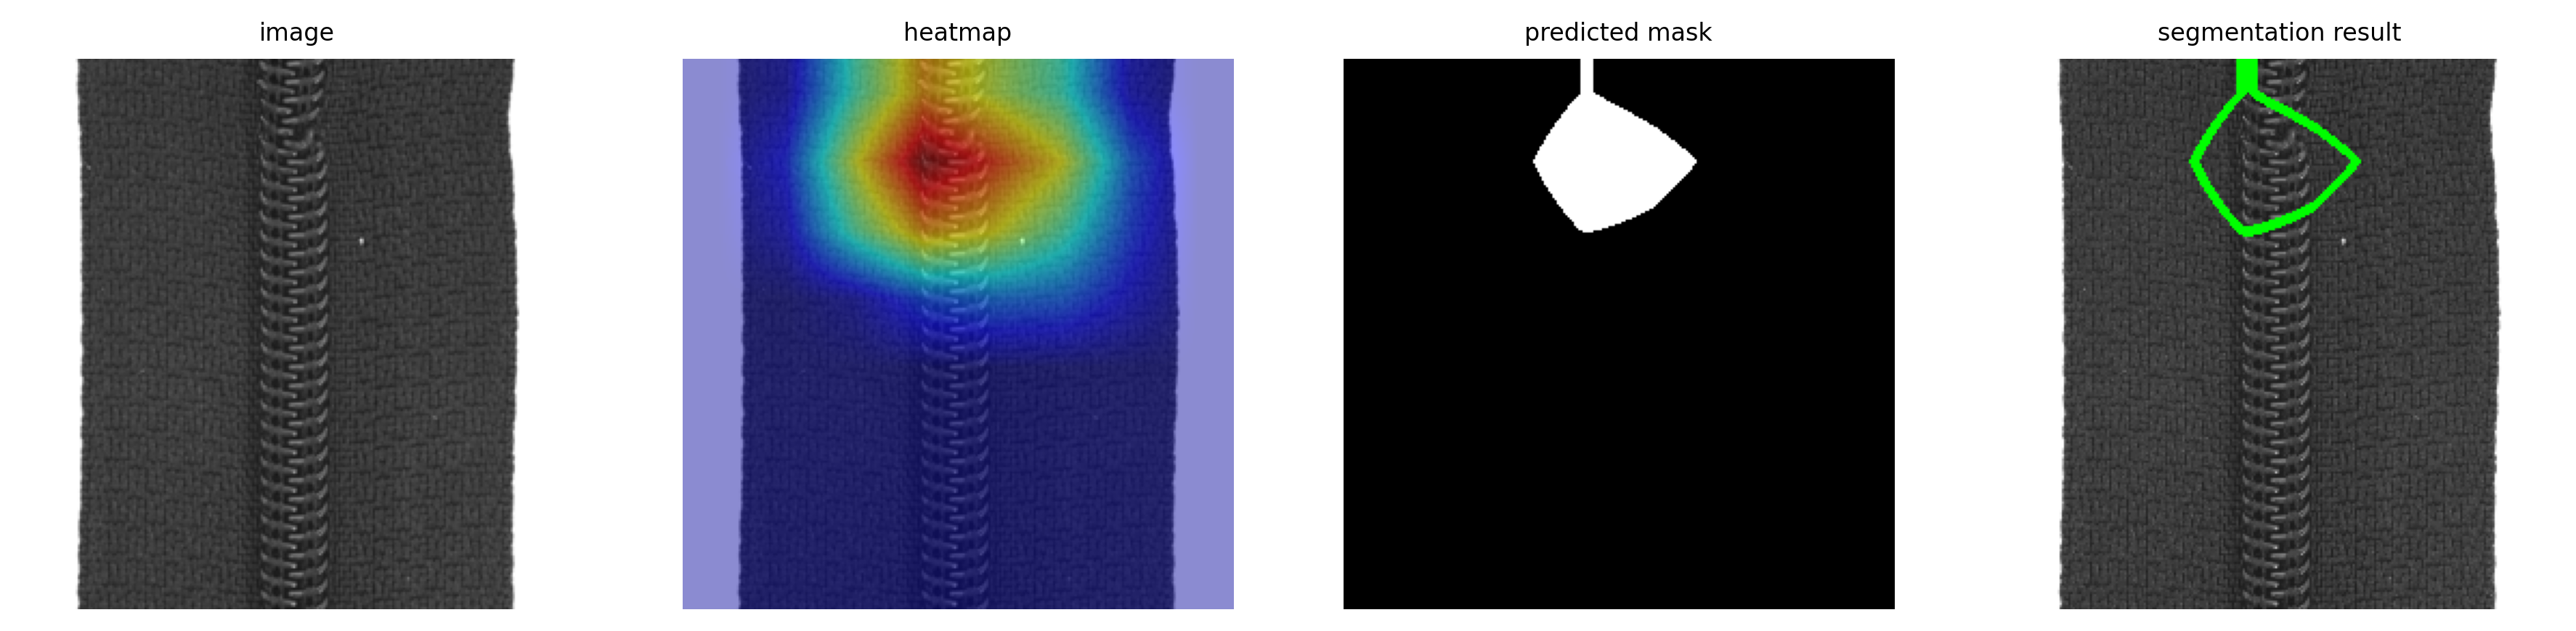

In [46]:
for vis_group in visualizations:
    fig, axes = plt.subplots(1,4)
    fig.set_dpi(300)
    axes[0].imshow(actual_img_norm)
    axes[0].axis("off")
    axes[0].set_title("image", fontdict=fontdict)
    axes[1].imshow(defect_cam_heatmap)
    axes[1].axis("off")
    axes[1].set_title("heatmap", fontdict=fontdict)
    axes[2].imshow(binary_cam, cmap='gray')
    axes[2].axis("off")
    axes[2].set_title("predicted mask", fontdict=fontdict)
    axes[3].imshow(segmented_defect)
    axes[3].axis("off")
    axes[3].set_title("segmentation result", fontdict=fontdict)
    axes[4].imshow(ground_truth_mask)
    axes[4].axis("off")
    axes[4].set_title("ground truth mask", fontdict=fontdict)

